In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as spatial
import folium
import random
import networkx as nx
import osmnx as ox
from scipy.spatial import cKDTree

In [2]:
restaurants = pd.read_csv('restaurants.csv')
shelters = pd.read_csv('shelters.csv')

In [72]:
#shelters.pop('Unnamed: 2')

In [3]:
chain_restaurants = restaurants[restaurants['businessname'].str.contains(
    'Dunkin|McDonald|Burger King|Pizza Hut|Wendy|Panda Express|Eataly|Sweetgreen|Cava|Chipotle|California Pizza Kitchen|Shake Shack|Panera Bread|Subway|Five Guys|TGI Fridays|The Cheesecake Factory|Red Lobster|Olive Garden|Buffalo Wild Wings|Starbucks|Auntie Anne\'s|Nando\'s|Domino\'s|IHop|Applebee\'s|Cracker Barrel|Hooters|Arby\'s|KFC|Jack in the Box|Tim Hortons|Wingstop|Jimmy John\'s|Papa John\'s|Sonic|Zaxby\'s|Hardee\'s|Taco Bell|Whataburger|Moe\'s Southwest Grill|Bojangles|Denny\'s|Church\'s Chicken|Captain D\'s|Raising Cane\'s|Jersey Mike\'s|Steak \'n Shake|Cold Stone Creamery|Baskin-Robbins|Papa Murphy\'s|Lenny\'s Sub Shop|Wingstreet|Del Taco|Maggiano\'s Little Italy|Ted\'s Montana Grill|The Melting Pot|El Jefe\'s|Tatte', 
    case=False)]
short_chain_restaurants = chain_restaurants[['businessname', 'latitude', 'longitude']].dropna()
short_chain_restaurants = short_chain_restaurants[short_chain_restaurants['latitude'] > 40]

In [4]:
short_chain_restaurants.to_csv('short_chain_restaurants.csv', index=False)

Text(0, 0.5, 'Latitude')

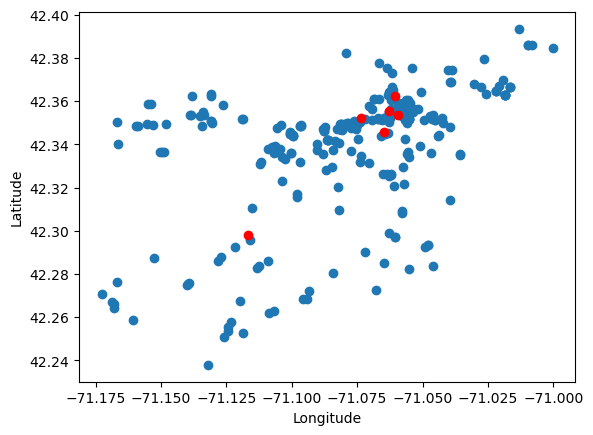

In [5]:
plt.scatter(short_chain_restaurants['longitude'], short_chain_restaurants['latitude'])
plt.scatter(shelters['Longitude'], shelters['Latitude'], color = 'red')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [14]:
short_chain_restaurants

,businessname,latitude,longitude,closest_node
125,APPLEBEE'S NEIGHBORHOOD GRILL & BAR,42.326087,-71.063612,61414954
147,Auntie Anne's Pretzels/ Carvel,42.351959,-71.055027,61444579
406,Buffalo Wild Wings Go/Sp. AS2-A18,42.364539,-71.021818,2077018736
415,Burger King,42.309265,-71.057753,6755664441
416,Burger King,42.356314,-71.061921,61341178
...,...,...,...,...
2758,The Cheesecake Factory,42.346860,-71.080891,61374390
2814,The Olive Garden Italian Restaurant # 1674,42.326302,-71.065272,61348104
3039,Wendy's,42.346437,-71.087600,61342883
3040,Wendy's,42.354120,-71.058980,61469330


In [15]:

# Create a folium map centered around the average latitude and longitude
m = folium.Map(location=[short_chain_restaurants['latitude'].mean(), short_chain_restaurants['longitude'].mean()], zoom_start=12)

# Add short chain restaurants to the map
for idx, row in short_chain_restaurants.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=5, color='blue', fill=True).add_to(m)

# Add shelters to the map
for idx, row in shelters.iterrows():
    folium.CircleMarker(location=[row['Latitude'], row['Longitude']], radius=5, color='red', fill=True).add_to(m)

# Save map as HTML file or display it
m.save('map.html')


In [16]:
from folium.plugins import MarkerCluster

# Convert restaurant and shelter DataFrames to coordinate arrays
restaurant_coords = short_chain_restaurants[['longitude', 'latitude']].values
shelter_coords = shelters[['Longitude', 'Latitude']].values

# Build a KDTree for shelters
shelter_tree = spatial.cKDTree(shelter_coords)

# Find the closest shelter for each restaurant
distances, indices = shelter_tree.query(restaurant_coords)

# Create a folium map centered around the mean of the restaurants' coordinates
map_center = [short_chain_restaurants['latitude'].mean(), short_chain_restaurants['longitude'].mean()]
folium_map = folium.Map(location=map_center, zoom_start=13)

# Add shelter markers to the map
shelter_cluster = MarkerCluster().add_to(folium_map)
for idx, shelter in shelters.iterrows():
    folium.Marker(
        location=[shelter['Latitude'], shelter['Longitude']],
        popup=f"Shelter {shelter.name}",
        icon=folium.Icon(color='red', icon='cloud')
    ).add_to(shelter_cluster)

# Add restaurant markers to the map
restaurant_cluster = MarkerCluster().add_to(folium_map)
for idx, restaurant in short_chain_restaurants.iterrows():
    folium.Marker(
        location=[restaurant['latitude'], restaurant['longitude']],
        popup=f"Restaurant {restaurant.name}",
        icon=folium.Icon(color='blue', icon='coffee')
    ).add_to(restaurant_cluster)

# Add lines from each restaurant to its closest shelter
for i in range(len(short_chain_restaurants)):  # Loop through restaurants
    # Get the closest shelter index
    closest_shelter_index = indices[i]
    closest_shelter = shelters.iloc[closest_shelter_index]
    
    # Add a line from restaurant to the closest shelter
    folium.PolyLine(
        locations=[
            [short_chain_restaurants.iloc[i]['latitude'], short_chain_restaurants.iloc[i]['longitude']],
            [closest_shelter['Latitude'], closest_shelter['Longitude']]
        ],
        color='blue',
        weight=2,
        opacity=0.6
    ).add_to(folium_map)

# Show the map
folium_map.save("restaurants_and_shelters_map.html")
folium_map


In [27]:
import osmnx as ox

# Define address and create graph
latitude = 42.3261495
longitude = -71.0928603
DISTANCE = 7500  # Distance in meters

# Create the graph from latitude and longitude
G = ox.graph_from_point((latitude, longitude), dist=DISTANCE, network_type="drive", truncate_by_edge=True)

In [28]:
# Extract latitude and longitude from the DataFrame
shelter_latitudes = shelters.iloc[:, 1].values  # Second column (latitude)
shelter_longitudes = shelters.iloc[:, 2].values  # Third column (longitude)

shelter_closest_nodes = [ox.nearest_nodes(G, X=lon, Y=lat) for lat, lon in zip(shelter_latitudes, shelter_longitudes)]
shelters["closest_node"] = shelter_closest_nodes


In [29]:
rest_latitudes = short_chain_restaurants.iloc[:, 1].values  # Second column (latitude)
rest_longitudes = short_chain_restaurants.iloc[:, 2].values  # Third column (longitude)

# Find closest nodes for each restaurant
restaurant_closest_nodes = [ox.nearest_nodes(G, X=lon, Y=lat) for lat, lon in zip(rest_latitudes, rest_longitudes)]
short_chain_restaurants["closest_node"] = restaurant_closest_nodes

In [30]:
#map_network = ox.truncate.largest_component(G, strongly=True)
#G = map_network

# Create a function to get the shortest distance between two nodes (restaurant to shelter)
def get_shortest_path_length(G, source_node, target_node):
    """
    Calculate the shortest path length between source_node and target_node.
    Uses Dijkstra's algorithm under the hood.
    """
    try:
        return nx.shortest_path_length(G, source=source_node, target=target_node, weight='length')
    except nx.NetworkXNoPath:
        return float('inf')  # In case no path exists

# Example list of restaurants and shelters (node IDs from the map)
restaurant_nodes = short_chain_restaurants["closest_node"]  # Convert to a list of node IDs
shelter_nodes = shelters["closest_node"] # Convert to a list of node IDs

# Create a function to compute distances between all restaurants and shelters
def calculate_distances(G, restaurant_nodes, shelter_nodes):
    distances = {}
    for restaurant in restaurant_nodes:
        for shelter in shelter_nodes:
            distance = get_shortest_path_length(G, restaurant, shelter)
            distances[(restaurant, shelter)] = distance
    return distances

# Calculate all distances between restaurants and shelters
distances = calculate_distances(G, restaurant_nodes, shelter_nodes)

# Example greedy algorithm to assign shelters to restaurants based on shortest path
def greedy_assignment(distances, restaurant_nodes, shelter_nodes):
    assignment = {}
    
    for restaurant in restaurant_nodes:
        # Find the closest shelter
        closest_shelter = None
        min_distance = float('inf')
        for shelter in shelter_nodes:
            distance = distances.get((restaurant, shelter), float('inf'))
            if distance < min_distance:
                closest_shelter = shelter
                min_distance = distance
        
        if closest_shelter is not None:
            if restaurant not in assignment:
                assignment[restaurant] = []
            assignment[restaurant].append(closest_shelter)
    
    return assignment

# Apply the greedy assignment
restaurant_to_shelter = greedy_assignment(distances, restaurant_nodes, shelter_nodes)

# Print the assignment
print(restaurant_to_shelter)

{61414954: [61479672], 61444579: [61339951, 61339951, 61339951, 61339951], 2077018736: [61339951, 61339951, 61339951], 6755664441: [61479672], 61341178: [61341429], 2938498073: [61339951, 61339951], 61343981: [61340922], 61344353: [61479672], 61361873: [1527825822], 61366079: [1527825822], 8689584230: [61339951, 61339951], 61411853: [1527825822, 1527825822], 61363176: [1527825822], 61380211: [61340922, 61340922, 61340922, 61340922, 61340922, 61340922, 61340922], 61363899: [61341317, 61341317, 61341317], 61480626: [61340922, 61340922, 61340922], 61342413: [61340922, 61340922, 61340922], 61366339: [1527825822], 61581816: [1527825822], 2981197212: [61479672, 61479672], 6462995309: [61340922], 61341694: [61340922, 61340922], 4546573131: [61341317, 61341317], 61355653: [61341317, 61341317], 61354584: [61341317, 61341317], 61344483: [61339951], 61367864: [1527825822], 61352265: [61339951], 61364398: [1527825822], 10181616032: [1527825822, 1527825822], 61362630: [1527825822], 61371500: [61479

In [37]:
import folium
import networkx as nx
import osmnx as ox

# Function to convert node positions from the graph to lat-lon coordinates
def get_node_positions(G):
    positions = {}
    for node in G.nodes:
        if 'x' in G.nodes[node] and 'y' in G.nodes[node]:
            positions[node] = (G.nodes[node]['y'], G.nodes[node]['x'])  # Note that OSMnx uses (lat, lon)
    return positions

# Get positions for all nodes in the graph
node_positions = get_node_positions(G)

# Extract positions for restaurants and shelters
restaurant_positions = {node: node_positions[node] for node in restaurant_nodes if node in node_positions}
shelter_positions = {node: node_positions[node] for node in shelter_nodes if node in node_positions}

# Create a Folium map centered around the average latitude and longitude
avg_lat = sum([pos[0] for pos in restaurant_positions.values()]) / len(restaurant_positions)
avg_lon = sum([pos[1] for pos in restaurant_positions.values()]) / len(restaurant_positions)
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=14)

# Add markers for restaurants (blue) and shelters (red)
for restaurant, pos in restaurant_positions.items():
    folium.Marker(location=pos, popup=f"Restaurant {restaurant}",
                  icon=folium.Icon(color='blue', icon='cutlery', prefix='fa')).add_to(m)

for shelter, pos in shelter_positions.items():
    folium.Marker(location=pos, popup=f"Shelter {shelter}",
                  icon=folium.Icon(color='red', icon='home', prefix='fa')).add_to(m)

# Plot shortest paths between restaurants and shelters
for restaurant, shelters in restaurant_to_shelter.items():
    for shelter in shelters:
        if restaurant in restaurant_positions and shelter in shelter_positions:
            # Get the shortest path between the restaurant and shelter
            path = nx.shortest_path(G, source=restaurant, target=shelter, weight='length')
            
            # Get the lat-lon coordinates for the path
            path_coords = [(node_positions[node][0], node_positions[node][1]) for node in path]
            
            # Plot the path as a polyline
            folium.PolyLine(path_coords, color='green', weight=2.5, opacity=0.7).add_to(m)

# Display the map
m.save('restaurants_and_shelters_map.html')
m
